# 本週末(2021/07/10-11)作業
擷取高科大所有的焦點新聞內容，放在資料庫中，然後從資料庫中取出這些內容，利用jieba斷詞之後，再送到WordCloud製作成文字雲。文字雲使用的圖片要另行設計喔。

In [1]:
# Retrieve articles title, date, link and context thru
# https://www.nkust.edu.tw/p/403-1000-12-1.php
# and store in database.

%matplotlib inline
import requests
import time
import sqlite3
from bs4 import BeautifulSoup as bs

# generate url thru given page.
def urlGen(page :int =1):
    return 'https://www.nkust.edu.tw/p/403-1000-12-{}.php'.format(page)

# retrieve article context thtu given url.
# await 500ms for the good practice of not getting banned
def getContext(url):
    cHtml =requests.get(url).text
    cSoup =bs(cHtml,"html.parser")
    cSel ='#Dyn_2_3 > div.module.module-detail.md_style1 > div > section > div.mcont > div.mpgdetail'
    r =cSoup.select(cSel)[0].text.strip().replace('\n','')
    time.sleep(0.5)
    return r

# log the status of retrieving article
def logAdd(srcUrl:str, contextUrl:str, status:str ='ok'):
    log.append('{} {} {}'.format(srcUrl,contextUrl,status))
    print(log[-1])


# get total page urls, put into srcUrls
html =requests.get(urlGen()).text
soup =bs(html,"html.parser")
totalPageSel ='#Dyn_2_3 > div > section > div.mpgbar > nav > span'
soup.select(totalPageSel)
pages =int(soup.select(totalPageSel)[0].text.strip()[1:-1])
srcUrls =[]  # collection of source urls that contain article
for p in range(1,pages+1):
    srcUrls.append(urlGen(page =p))

# get article title, date, link and context
article =list()
log =list()
pageListSel ='#pageptlist > div > div > div > div > div'
for su in srcUrls:
    curSrcHtml =requests.get(su).text
    curSrcSoup =bs(curSrcHtml,"html.parser")
    pageList =curSrcSoup.select(pageListSel)
    try:
        for pageItem in pageList:
            temp =dict()
            temp['title'] =pageItem.a.text.strip()
            temp['context'] =getContext(url =pageItem.a['href'])
            temp['link'] =pageItem.a['href']
            temp['date'] =pageItem.i.text
            article.append(temp)
            logAdd(srcUrl=su.split('/')[-1],contextUrl=pageItem.a['href'].split('/')[-1])
        time.sleep(0.5)
    except Exception as e:
        logAdd(srcUrl=su.split('/')[-1],contextUrl=pageItem.a['href'],status ='failed. {}'.format(e))
        pass
print('done')

# write logfile
with open('nkust_news.log','w') as f:
    f.writelines([(lg+'\n') for lg in log])

# store into database
conn =sqlite3.connect("nkust_news.db")
for a in article:
    try:
        sqlStr ="INSERT INTO news('date','title','link','context') VALUES('{}','{}','{}','{}')".format(
            a['date'],a['title'],a['link'],a['context'])
        conn.execute(sqlStr)
        conn.commit()
    except:
        pass
conn.close()

403-1000-12-1.php 406-1000-45512,r12.php ok
403-1000-12-1.php 406-1000-45363,r12.php ok
403-1000-12-1.php 406-1000-44473,r12.php ok
403-1000-12-1.php 406-1000-44187,r12.php ok
403-1000-12-1.php https://2019-ncov.nkust.edu.tw/p/404-1123-44159-1.php failed. list index out of range
403-1000-12-2.php https://www.nkust.edu.tw/p/406-1000-43120,r12.php failed. list index out of range
done


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\KENNET~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.561 seconds.
Prefix dict has been built successfully.


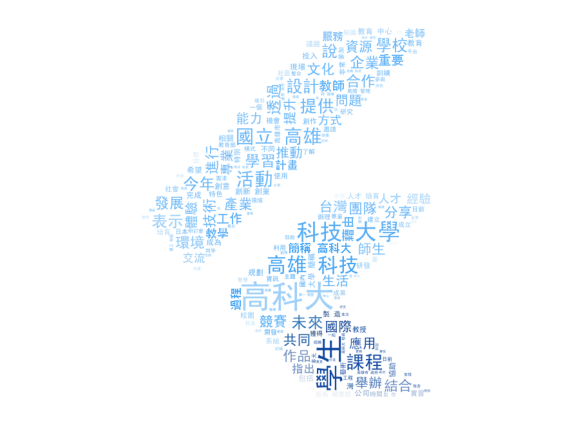

In [2]:
# Generate WordCloud thru context in db

import sqlite3
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud,ImageColorGenerator
import numpy as np
import os
import jieba

conn =sqlite3.connect("nkust_news.db")
db =conn.execute('SELECT context FROM news')
contexts =db.fetchall()
db.close()

data =list()
for c in contexts:
    data.append(c[0])
data =','.join(data)

stopwords = list()
with open('stopWords.txt', 'r', encoding='utf-8') as fp:
    stopwords = [word.strip() for word in fp.readlines()]

jieba.load_userdict("userDict.txt")
keyterms = [keyterm for keyterm in jieba.cut(data) if keyterm not in stopwords]
keyterms = ','.join(keyterms)

mask = np.array(Image.open('flutter.jpg'))
wordcloud = WordCloud(background_color='white',
                      width=1000, height=860, 
                      margin=2, font_path="simhei.ttf",
                      mask=mask).generate(keyterms)
sampled_colors = ImageColorGenerator(mask,default_color='blue') # image color sampling

plt.figure(figsize=(10,10))
plt.imshow(wordcloud.recolor(color_func=sampled_colors))
plt.axis("off")
plt.show()